# One-dimensional packed-bed, catalytic-membrane reactor model without streamwise diffusion

The present model simulates heterogeneous catalytic processes inside packed-bed, catalytic membrane reactors. The gas-phase and surface-phase species conservation equations are derived and the system of differential-algebraic equations (DAE) is solved using the scikits.odes.dae IDA solver.

In [1]:
# Import Cantera and scikits
import numpy as np
from scikits.odes import dae
import cantera as ct
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats = ["svg"]
print("Runnning Cantera version: " + ct.__version__)

Runnning Cantera version: 2.6.0


## Methodology

One-dimensional, steady-state catalytic-membrane reactor model with surface chemistry is developed to analyze species profiles along the length of a packed-bed, catalytic membrane reactor. The same model can further be simplified to simulate a simple packed-bed reactor by excluding the membrane. The example here demonstrates the one-dimensional reactor model explained by G. Kogekar, et al., "Efficient and robust computational models of  heterogeneous catalysis in catalytic membrane reactors," (2022), In preparation [1].

### Governing equations

Assuming steady-state, one-dimensional flow within the packed bed, total-mass, species mass and energy conservation may be stated as [2]

$$
    \frac{d(\rho u)}{dz} = \sum_{k=1}^{K_{\mathrm{g}}} \dot {s}_k W_k A_{\mathrm{s}} + \frac{P_{\mathrm b}}{A_{\mathrm b}}       j_{k_{\mathrm M}}, \\
    \rho u \frac{dY_k}{dz} + A_{\mathrm{s}} Y_k \sum_{k=1}^{K_{\mathrm{g}}} \dot {s}_k W_k  =  A_{\mathrm s} \dot {s}_k W_k    + \delta_{k, k_{\mathrm M}} \frac{P_{\mathrm b}}{A_{\mathrm b}} j_{k_{\mathrm M}}, \\
    \rho u c_{\mathrm p} \frac{dT}{dz} + \sum_{k=1}^{K_{\mathrm g}} h_k (\phi_{\mathrm g} \dot {\omega}_k +  A_{\mathrm s} \dot {s}_k) W_k = \hat h \frac{P_{\mathrm b}}{A_{\mathrm b}}(T_{\mathrm w} - T) + \delta_{k, k_{\mathrm M}} \frac{P_{\mathrm b}}{A_{\mathrm b}} h_{k_{\rm M}}  j_{k_{\mathrm M}}.
$$

The fractional coverages of the $K_{\rm s}$ surface adsorbates $\theta_k$ must satisfy 
$$
    \dot {s}_k = 0,     {\ \ \ \ \ \ } (k = 1,\ldots, K_{\mathrm s}),
$$
which, at steady state, requires no net production/consumption of surface species by the heterogeneous reactions [3].

The pressure within the bed is calculated as
$$ 
    \frac{dp}{dz} = - \left( \frac{\phi_{\mathrm{g}} \mu}{\beta_{\mathrm{g}}} \right) u,
$$
where $\mu$ is the gas-phase mixture viscosity. The packed-bed permeability $\beta_{\rm g}$ is evaluated using the Kozeny-Carman relationship as 
$$
    \beta_{\mathrm g} = \frac{\phi_{\mathrm{g}}^3 D_{\mathrm p}^2}{72 \tau_{\mathrm{g}}(1 - \phi_{\mathrm{g}})^2},
$$
where $\phi_{\mathrm{g}}$, $\tau_{\mathrm{g}}$, and $D_{\mathrm {p}}$ are the bed porosity, tortuosity, and particle diameter, respectively.

The independent variable in these conservation equations is the position $z$ along the reactor length. The dependent variables include total mass flux $\rho u$, pressure $p$, temperature $T$, gas-phase mass fractions $Y_k$, and surfaces coverages $\theta_k$. Gas-phase fluxes through the membrane are represented as $j_{k, {\mathrm M}}$. Geometric parameters $A_{\mathrm s}$, $P_{\mathrm b}$, and $A_{\mathrm b}$ represent the catalyst specific surface area (dimensions of surface area per unit volume), reactor perimeter, and reactor cross-sectional flow area, respectively. Other parameters include bed porosity $\phi_{\mathrm g}$ and gas-phase species molecular weights $W_k$. The gas density $\rho$ is evaluated using the equation of state (ideal Eos, RK or PR EoS).

If a perm-selective membrane is present, then $j_{k_{\mathrm M}}$ represents the gas-phase flux through the membrane and ${k_{\mathrm M}}$ is the gas-phase species that permeates through the membrane. The Kronecker delta, $\delta_{k, k_{\mathrm M}} = 1$ for the membrane-permeable species and  $\delta_{k, k_{\mathrm M}} = 0$ otherwise. The membrane flux is calculated using Sievert's law as
$$
    {j_{k_{\mathrm M}}}^{\text{Mem}} = \frac{B_{k_{\mathrm M}}}{t} \left ( p_{k_{\mathrm M} {\text{, mem}}}^\alpha - p_{k_{\mathrm M} \text{, sweep}}^\alpha \right ) W_{k_{\rm M}}
$$
where $B_{k_{\mathrm M}}$ is the membrane permeability, $t$ is the membrane thickness. $p_{k_{\mathrm M} \text{, mem}}$ and $p_{k_{\mathrm M} \text{, sweep}}$ represent perm-selective species partial pressures within the packed-bed and the exterior sweep channel. The present model takes the pressure exponent $\alpha$ to be unity. The membrane flux for all other species ($ k \neq k_{\mathrm M}$) is zero.

### Chemistry mechanism
This example uses a detailed 12-step elementary micro-kinetic reaction mechanism that describes ammonia formation and decomposition kinetics over the Ru/Ba-YSZ catalyst. The reaction mechanism is developed and validated using measured performance in a laboratory-scale packed-bed reactor [4]. This example also incorporates a Pd-based H<sub>2</sub> perm-selective membrane.


### Solver

Above governing equations represent a complete solution for a steady-state packed-bed, catalytic membrane reactor model. The dependent variables are the mass-flux $\rho u$, species mass-fractions $Y_k$, pressure $p$, temperature $T$, and surface coverages $\theta_k$. The equation of state is used to obtain the mass density, $\rho$.

The governing equations form an initial value problem (IVP) in a differential-algebraic (DAE) form as follows:
$$
   f(z,{\bf{y}}, \bf {y'}, c) = 0,
$$
where $\bf{y}$ and $\bf{y'}$ represent the solution vector and its derivative vector, respectively. All other constants such as reference temperature, chemical constants, etc. are incorporated in vector $c$ (Refer to [5] for more details). This type of DAE system in this example is solved using the `scikits.odes.dae` IDA solver.
> 1. G. Kogekar, H. Zhu, R.J. Kee, 'Efficient and robust computational models of  heterogeneous catalysis in catalytic membrane reactors', (2022), In preparation
> 2. B. Kee, C. Karakaya, H. Zhu, S. DeCaluwe, and R.J. Kee, 'The Influence of Hydrogen-Permeable Membranes and Pressure on Methane Dehydroaromatization in Packed-Bed Catalytic Reactors', Industrial & Engineering Chemistry Research (2017) 56, 13:3551 - 3559
> 3. R.J. Kee, M.E. Coltrin, P. Glarborg, and H. Zhu, 'Chemically Reacting Flow: Theory, Modeling and Simulation', Wiley (2018)
> 4. Z. Zhang, C. Karakaya, R.J. Kee, J. Douglas Way, C. Wolden,, 'Barium-Promoted Ruthenium Catalysts on Yittria-Stabilized Zirconia Supports for Ammonia Synthesis', ACS Sustainable Chemistry & Engineering (2019) 7:18038 - 18047
> 5. G. Kogekar, 'Computationally efficient and robust models of non-ideal thermodynamics, gas-phase kinetics and heterogeneous catalysis in chemical reactors' (2021), Doctoral dissertation. 

### Define gas-phase and surface-phase species

In [2]:
# Import the reaction mechanism file 
yaml_file = 'multifacet_edge_all.yaml'      # Default
#yaml_file = 'multifacet_covdep_all.yaml'   # Simulation with coverage dependent thermodynamics

# Import the models for gas-phase
gas = ct.Solution(yaml_file, 'gas')

# input file containing the surface reaction mechanism
# import the (111) surface
surf111 = ct.Interface(yaml_file,'surface1', [gas])
    
# Other parameters
n_gas = gas.n_species  # number of gas species
n_surf = surf111.n_species 
n_gas_reactions = gas.n_reactions

# Set offsets of dependent variables in the solution vector
offset_rhou = 0
#offset_p = 1
offset_T = 1
offset_Y = 2
offset_Z = offset_Y + n_gas
n_var = offset_Z + n_surf  # total number of variables (rhou, T, Yk and Zk)

print("Number of gas-phase species = ", n_gas)
print("Number of surface-phase species = ", n_surf)
print("Number of variables = ", n_var)
print("Number of gas-phase reactions = ", n_gas_reactions)

Number of gas-phase species =  6
Number of surface-phase species =  6
Number of variables =  14
Number of gas-phase reactions =  0


### Define reactor geometry and operating conditions

In [46]:
# Reactor geometry
L = 5e-3  # length of the reactor (m)
R = 2e-3  # radius of the reactor channel (m)
phi = 1.0  # porosity of the bed (-)
#tau = 2.0  # tortuosity of the bed (-)
#dp = 3.37e-4  # particle diameter (m)
As = 3.5e10 # specific surface area (1/m)

# Energy (adiabatic or isothermal)
#solve_energy = True  # True: Adiabatic, False: isothermal

# Get required properties based on the geometry and mechanism
W_g = gas.molecular_weights  # vector of molecular weight of gas species
#area2vol = 2 / R  # area to volume ratio assuming a cylindrical reactor
#D_h = 2 * R  # hydraulic diameter

# Inlet operating conditions
T_in = 378  # inlet temperature [K]
p_in = 1e5  # inlet pressure [Pa]
v_in = 0.001  # inlet velocity [m/s]
#T_wall = 723  # wall temperature [K]
#h_coeff = 1e2  # heat transfer coefficient [W/m2/K]

# Set gas and surface states
#gas.TPX = T_in, p_in, 'He:0.9013, CO2:0.0987' #'Ar:1, CO2:0.0, CO:0, H2:0'  # inlet composition
gas.TPX = T_in, p_in, 'He:0.85, CO:0.1, O2: 0.05' #'Ar:1, CO2:0.0, CO:0, H2:0'  # inlet composition
Yk_0 = gas.Y
rhou0 = gas.density * v_in

surf111.TP = T_in, p_in
surf111.coverages = {'site(111)':1, 'H(111)':0, 'O(111)':0, 'OC(111)':0 , 'CO2(111)':0}

# advancing coverages over a long period of time to get the steady state.
t = 1e10
surf111.advance_coverages(t)  
Zk_111 = surf111.coverages

SyntaxError: invalid syntax (1123283777.py, line 7)

### Define residual function required for IDA solver

In [47]:
def residual(z, y, yPrime, res, ind):
    """Solution vector for the model
    y = [rho*u, T, Yk, Zk]
    yPrime = [d(rho*u)dz, dTdz, dYkdz, dZkdz]
    """
    # Get current thermodynamic state from solution vector and save it to local variables.
    rhou = y[offset_rhou]  # mass flux (density * velocity)
    Y = y[offset_Y : offset_Y + n_gas]  # vector of mass fractions
    Z = y[offset_Z : offset_Z + n_surf] # vector of site fractions 
    p = p_in   # pressure
    T = y[offset_T]  # temperature

    # Get derivatives of dependent variables
    drhoudz = yPrime[offset_rhou]  
    dYdz = yPrime[offset_Y : offset_Y + n_gas] 
    dZdz = yPrime[offset_Z : offset_Z + n_surf] 
    #dpdz = yPrime[offset_p]  
    dTdz = yPrime[offset_T] 
    
    # Set current thermodynamic state for the gas and surface phases
    # Note: use unnormalized mass fractions and site fractions to avoid over-constraining the system
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T, p
    
    # Use unnormalized site fractions (coverages) to avoid over-constraining the system
    #surf110.set_unnormalized_coverages(z110)
    surf111.coverages = Z
    surf111.TP = T, p
    z111 = surf111.coverages
    
    # heterogeneous production rate of gas species
    sdot_s = np.zeros(n_surf)
    sdot_g = surf111.get_net_production_rates("gas")
    #print(sdot_g)
    sdot_s = surf111.get_net_production_rates("surface1")
    
    # heterogeneous production rate of surface species
    wdot_g = np.zeros(n_gas)

    if n_gas_reactions > 0:
        # homogeneous production rate of gas species
        wdot_g = gas.net_production_rates  

    # Calculate density using equation of state
    rho = gas.density

    # Conservation of total-mass
    # temporary variable
    sum_continuity = phi * np.sum(wdot_g * W_g) + As * np.sum(sdot_g * W_g)  
    #print(sum_continuity)
    res[offset_rhou] = drhoudz - sum_continuity

    # Conservation of gas-phase species        
    res[offset_Y:offset_Y+ n_gas] = (dYdz + (Y * sum_continuity - phi * np.multiply(wdot_g, W_g) 
                                     - As * np.multiply(sdot_g, W_g)) / rhou)
    alg_gas = offset_Y + np.argmax(Y)
    #res[alg_gas] = 1 - np.sum(Y)
    
    # Conservation of site fractions (algebraic constraints in this example)
    res[offset_Z : offset_Z + n_surf] = sdot_s

    # For the species with the largest site coverage (k_large), solve the constraint equation: sum(Zk) = 1
    # The residual function for 'k_large' would be 'res[k_large] = 1 - sum(Zk)'
    # Note that here, sum(Zk) will be the sum of coverages for all surface species, including the 'k_large' species.
    alg_111 =  offset_Z + np.argmax(z111)
    #res[alg_111] = 1 - np.sum(Z)
    
    # Conservation of energy
    res[offset_T] = dTdz - 0  # isothermal condition

### Calculate the spatial derivatives at the inlet that will be used as the initial conditions for the IDA solver


In [48]:
# Initialize yPrime to 0 and call residual to get initial derivatives
y0 = np.hstack((rhou0, T_in, Yk_0, Zk_111))
#print(y0)
yprime0 = np.zeros(n_var)
res = np.zeros(n_var)
ind = np.zeros(4)
residual(0, y0, yprime0, res, ind)
yprime0 = -res
print(y0)
print(res)

[2.48280058e-02 3.78000000e+02 0.00000000e+00 4.36007048e-01
 0.00000000e+00 0.00000000e+00 3.58959362e-01 2.05033589e-01
 1.58068239e-09 2.23463292e-35 9.99999998e-01 3.66136089e-28
 3.90756097e-50 0.00000000e+00]
[ 1.01365814e-13  0.00000000e+00  0.00000000e+00 -1.78009502e-12
 -7.17789871e-32  0.00000000e+00  2.61718990e-12 -8.37094886e-13
 -1.03397577e-25  0.00000000e+00  1.03397577e-25  1.15699004e-45
 -1.55575382e-61  0.00000000e+00]


### Solve the system of DAEs using ida solver

In [49]:
solver = dae(
    "ida",
    residual,
    first_step_size=1e-18,
    atol=1e-18,  # absolute tolerance for solution
    rtol=1e-12,  # relative tolerance for solution
    #algebraic_vars_idx=ind,
    #algebraic_vars_idx=[np.arange(offset_Y + n_gas, offset_Z + n_surf, 1)],
    max_steps=8000,
    one_step_compute=True,
    old_api=False,  # forces use of new api (namedtuple)
)

distance = []
solution = []
state = solver.init_step(0.0, y0, yprime0)

# Note that here the variable t is an internal variable used in scikits. In this example, it represents
# the natural variable z, which corresponds to the axial distance inside the reactor.
while state.values.t < L:
    distance.append(state.values.t)
    solution.append(state.values.y)
    state = solver.step(L)
    print(state)

distance = np.array(distance)
solution = np.array(solution)
print(state)

SolverReturn(flag=<StatusEnumIDA.CONV_FAIL: -4>, values=SolverVariables(t=None, y=None, ydot=None), errors=SolverVariables(t=array(0.), y=array([2.48280058e-02, 3.78000000e+02, 0.00000000e+00, 4.36007048e-01,
       0.00000000e+00, 0.00000000e+00, 3.58959362e-01, 2.05033589e-01,
       1.58068239e-09, 2.23463292e-35, 9.99999998e-01, 3.66136089e-28,
       3.90756097e-50, 0.00000000e+00]), ydot=array([-1.01365814e-13, -0.00000000e+00, -0.00000000e+00,  1.78009502e-12,
        7.17789871e-32, -0.00000000e+00, -2.61718990e-12,  8.37094886e-13,
        1.03397577e-25, -0.00000000e+00, -1.03397577e-25, -1.15699004e-45,
        1.55575382e-61, -0.00000000e+00])), roots=SolverVariables(t=None, y=None, ydot=None), tstop=SolverVariables(t=None, y=None, ydot=None), message='Convergence test failures occurred too many times during one internal time step or minimum step size was reached.')


TypeError: '<' not supported between instances of 'NoneType' and 'float'

### Plot results

TypeError: list indices must be integers or slices, not tuple

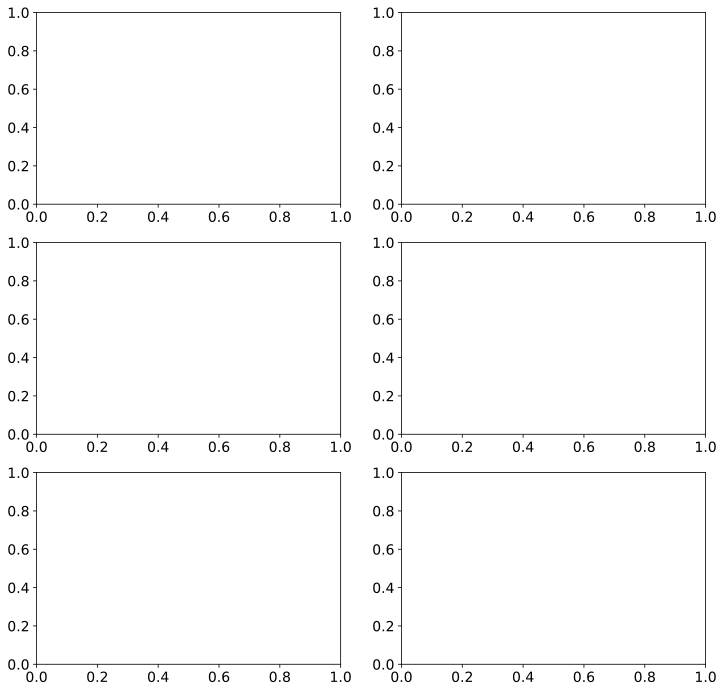

In [29]:
plt.rcParams["font.size"] = 14
f, ax = plt.subplots(3, 2, figsize=(12, 12), dpi=96)

# Plot gas pressure profile along the flow direction
#ax[0, 0].plot(distance, solution[:, offset_p], color="C0")
#ax[0, 0].set_xlabel("Distance (m)")
#ax[0, 0].set_ylabel("Pressure (Pa)")

# Plot gas temperature profile along the flow direction
ax[0, 1].plot(distance, solution[:, offset_T], color="C1")
ax[0, 1].set_xlabel("Distance (m)")
ax[0, 1].set_ylabel("Temperature (K)")

# Plot major and minor gas species separately
minor_idx = []
major_idx = []
for j, name in enumerate(gas.species_names):
    mean = np.mean(solution[:, offset_Y + j])
    if mean <= 0.1:
        minor_idx.append(j)
    else:
        major_idx.append(j)

# Plot mass fractions of the gas-phase species along the flow direction

# Major gas-phase species
for j in major_idx:
    ax[1, 0].plot(distance, solution[:, offset_Y + j], label=gas.species_names[j])
ax[1, 0].legend(fontsize=12, loc="best")
ax[1, 0].set_xlabel("Distance (m)")
ax[1, 0].set_ylabel("Mass Fraction")

# Minor gas-phase species
for j in minor_idx:
    ax[1, 1].plot(distance, solution[:, offset_Y + j], label=gas.species_names[j])
ax[1, 1].legend(fontsize=12, loc="best")
ax[1, 1].set_xlabel("Distance (m)")
ax[1, 1].set_ylabel("Mass Fraction")

# Plot major and minor surface species separately
minor_idx = []
major_idx = []
for j, name in enumerate(surf.species_names):
    mean = np.mean(solution[:, offset_Z + j])
    if mean <= 0.1:
        minor_idx.append(j)
    else:
        major_idx.append(j)

# Plot the site fraction of the surface-phase species along the flow direction
# Major surf-phase species
for j in major_idx:
    ax[2, 0].plot(distance, solution[:, offset_Z + j], label=surf.species_names[j])
ax[2, 0].legend(fontsize=12, loc="best")
ax[2, 0].set_xlabel("Distance (m)")
ax[2, 0].set_ylabel("Site Fraction")

# Minor surf-phase species
for j in minor_idx:
    ax[2, 1].plot(distance, solution[:, offset_Z + j], label=surf.species_names[j])
ax[2, 1].legend(fontsize=12, loc="best")
ax[2, 1].set_xlabel("Distance (m)")
ax[2, 1].set_ylabel("Site Fraction")
f.tight_layout()